# LSTM: Many-to-many setup

<span style="color:red;font-weight:bold"> For prototyping the LSTM model.</span>


In [2]:
import re
import numpy as np
import unidecode
from keras.preprocessing.sequence import pad_sequences
from IPython import get_ipython;   
#get_ipython().magic('reset -sf')
import pandas
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xushen/anaconda3/envs/carla_analysis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

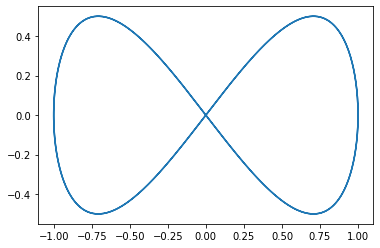

In [3]:
thetas = np.linspace(0,4*np.pi,1000)
dataset = np.array([np.sin(thetas),np.sin(thetas)*np.cos(thetas)]).T
dataset = dataset.astype('float32')
plt.plot(dataset[:,0],dataset[:,1])
plt.show()

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-look_back):
        print
        a = dataset[i:(i+look_back), :]
        b = dataset[(i+look_back):(i+look_back+look_back),:]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [5]:
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 20
trainX, trainY = create_dataset(train, look_back)
trainX.shape,trainY.shape

((630, 20, 2), (630, 20, 2))

In [6]:
# Add your import statements here
from keras import Input, Model
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, Embedding
from keras.layers.recurrent import LSTM

def create_model(X_seq_len,X_seq_feat,Y_seq_len,Y_seq_feat, hidden_dim):
    # Set up input shape to encoder
    encoder_input_layer = Input(shape=(X_seq_len,X_seq_feat))
    
    # Define encoder
    encoder = LSTM(hidden_dim,return_state=True)
    # Encoder outputs - but only consider the memory and weights
    encoder_outputs, state_h, state_c = encoder(encoder_input_layer)
    encoder_states = [state_h,state_c]
    
    # We need to feed the decoder some zero inputs that is uncorrelated
    null_input = Input(shape=[Y_seq_feat])
    repeated_null = RepeatVector(Y_seq_len)(null_input)
    
    # Define decoder
    decoder = LSTM(hidden_dim,return_sequences=True, return_state=True)
    decoder_outputs,_,_ = decoder(repeated_null,initial_state=encoder_states)
    decoder_fully_connected = TimeDistributed(Dense(Y_seq_feat))(decoder_outputs)
    
    # Create final model
    model = Model([encoder_input_layer,null_input], decoder_fully_connected)
    
    # Compile model using loss
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model
    

In [7]:
input_len = 20
input_feat = 2
output_len = 20
output_feat = 2
hidden_dim = 20
model = create_model(input_len,input_feat,
                     output_len,output_feat,hidden_dim)
x = trainX[:,:,:]
y = trainY[:,:,:]
z = np.zeros((len(x),output_feat))
model.fit([x,z],y,epochs=100)

Epoch 1/100
630/630 [==============================] - 2s 4ms/step - loss: 0.2918
Epoch 2/100
630/630 [==============================] - 1s 902us/step - loss: 0.2069
Epoch 3/100
630/630 [==============================] - 1s 861us/step - loss: 0.0963
Epoch 4/100
630/630 [==============================] - 1s 869us/step - loss: 0.0609
Epoch 5/100
630/630 [==============================] - 1s 852us/step - loss: 0.0440
Epoch 6/100
630/630 [==============================] - 1s 830us/step - loss: 0.0298
Epoch 7/100
630/630 [==============================] - 1s 801us/step - loss: 0.0160
Epoch 8/100
630/630 [==============================] - 1s 821us/step - loss: 0.0095
Epoch 9/100
630/630 [==============================] - 1s 825us/step - loss: 0.0068
Epoch 10/100
630/630 [==============================] - 1s 820us/step - loss: 0.0055
Epoch 11/100
630/630 [==============================] - 1s 823us/step - loss: 0.0045
Epoch 12/100
630/630 [==============================] - 1s 815us/step - loss

In [8]:
xp = model.predict([x,z])

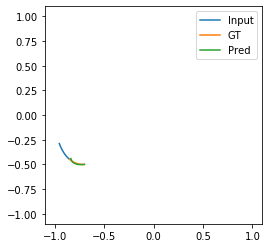

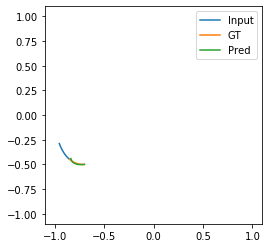

In [9]:
line, = plt.plot([],[],label='Input')
line1, = plt.plot([],[],label='GT')
line2, = plt.plot([],[],label='Pred')
plt.legend()
ax = plt.gca()
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_aspect('equal')
for i in range(400):
    line.set_data(trainX[i,:,0],trainX[i,:,1])
    line1.set_data(trainY[i,:,0],trainY[i,:,1])
    line2.set_data(xp[i,:,0],xp[i,:,1])
    display.clear_output(wait=True)
    display.display(plt.gcf()) 